## XGBoost(eXtra Gradient Boost)
분류에 있어서 다른 머신러닝보다 뛰어난 예측 성능을 나타냄  
GBM의 단점인 느린 수행 시간과 과적합 규제 부재 등의 문제를 해결함  

In [1]:
import xgboost as xgb
from xgboost import XGBClassifier

XGBoost는 GBM과 유사한 하이퍼 파라미터를 가지고 있음  
조기중단(early stopping)과 과적합을 규제하기 위한 하이퍼 파라미터 등이 추가  
파이썬 래퍼 XGBoost와 사이킷런 래퍼 XGBoost 모듈의 일부 하이퍼 파라미터는 이름이 다르므로 주의  

### 파이썬 래퍼 XGBoost 하이퍼 파라미터
일반 파라미터: 일반적으로 실행 시 스레드의 개수나 silent 모드 등의 선택을 위한 파라미터, 디폴트값을 바꾸는 경우는 거의 없음  
부스터 파라미터: 트리 최적화, 부스팅, regularization 등과 관련된 파라미터 등을 지칭  
학습 태스크 파라미터: 학습 수행 시의 객체 함수, 평가를 위한 지표 등을 설정하는 파라미터

### 주요 일반 파라미터
booster: gbtree, gblinear  
silent: 디폴트: 0, 출력 메시지를 나타내고 싶지 않을 경우 1  
nthread: CPU의 실행 스레드 개수 조정

### 주요 부스터 파라미터
eta: GBM의 학습률과 같은 파라미터. 파이썬 래퍼 기반 XGBoost의 경우 기본값 0.3, 사이킷런 래퍼 기반 XGBoost사용시 learning_rate 파라미터로 대체되며 기본값은 0.1  
num_boost_rounds: GBM의 n_estimators와 같은 파라미터  
min_child_weight: 트리에서 추가적으로 가지를 나눌 지 결정하기 위해 필요한 데이터들의 weight 총합. 클수록 분할을 자제. 과적합 조절용  
gamma: 트리의 리프 노드를 추가적으로 나눌 지를 결정할 최소 손실 감소 값. 해당 값보다 큰 손실이 감소된 경우에 리프 노드를 분리. 값이 클수록 과적합 감소 효과  
max_depth: 트리 기반 알고리즘의 max_depth와 같음  
sub_sample: GBM의 subsample과 동일. 트리가 커져서 과적합되는 것을 제어하기 위해 데이터를 샘플링하는 비율을 지정. 일반적으로 0.5~1사이 값 사용  
colsample_bytee: GBM의 max_features와 유사. 트리 생성에 필요한 피처를 임의로 샘플링  
lambda: L2 Regularization 적용 값. 피처 개수가 많은 경우 적용을 검토, 값이 클수록 과적합 감소 효과  
alpha: L1 Regularizaion 적용 값. 피처 개수가 많은 경우 적용을 검토, 값이 클수록 과적합 감소 효과  
scale_pos_weight: 특정 값으로 치우친 비대칭한 클래스로 구성된 데이터세트의 균형을 유지하기 위한 파라미터

### 학습 태스크 파라미터
objective: 최솟값을 가져야 할 손실함수 정의  
binary:logistic: 이진 분류일 때 적용  
multi:softmax: 다중 분류일 때 적용. 레이블 클래스의 개수인 num_class 파라미터 지정해야 함  
multi:softprob: multi:softmax와 유사하나 개별 레이블 클래스의 해당되는 예측 확률을 반환  
eval_metric: 검증에 사용되는 함수를 정의. 기본값은 회귀의 경우 rmse, 분류의 경우 error

### 과적합 문제가 심각하다면?
1. eta 값을 낮춘다. eta값을 낮출 경우 num_round(n_estimators)는 높여줘야 함
2. max_depth 값을 낮춘다
3. min_child_weight값을 높인다
4. gamma값을 높인다
5. subsample과 colsample_byree를 조정하는 것도 트리가 너무 복잡하게 생성되는 것을 막아 과적합 문제에 도움

XGBoost는 GBM과 다르게 조기중단 기능이 있어 n_estimators에 지정한 부스팅 횟수에 도달하지 않더라도 미리 중지해 수행 시간 개선 가능

In [3]:
#XGBoost 버전 확인
import xgboost
print(xgboost.__version__)

1.7.3


In [6]:
# 파이썬 래퍼 XGBoost적용 - 위스콘신 유방암 예측
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
features = dataset.data
labels = dataset.target

cancer_df = pd.DataFrame(data = features, columns = dataset.feature_names)
cancer_df['target'] = labels
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [7]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [9]:
#cancer_df에서 feature용 DataFrame과 Label용 Series객체 추출
#맨 마지막 칼럼이 Label임. Feature용 DataFrame은 cancer_df의 첫번째 칼럼에서 맨 마지막 두번째 칼럼까지를 :-1 슬라이싱으로 추출
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

#전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size = 0.2, random_state = 156)

#위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습과 10%는 검증용 데이터로 분리
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 156)

print(X_train.shape, X_test.shape)
print(X_tr.shape, X_val.shape)
#최종 학습용 409개, 검증용 46개, 테스트용 114개 추출

(455, 30) (114, 30)
(409, 30) (46, 30)


파이썬래퍼 XGBoost는 XGBoost만의 전용 데이터 객체인 DMatrix를 사용함  
때문에 Numpy나 Pandas로 되어 있는 학습,검증,테스트용 데이터셋을 모두 DMatrix로 생성하여 모델에 입력해야 함  
주요 입력 파라미터: data, label  
data: 피처 데이터 세트  
label: 분류의 경우 레이블 데이터셋, 회귀의 경우 숫자형인 종속값 데이터셋  

In [11]:
#학습, 검증, 테스트용 Dmatrix 생성
dtr = xgb.DMatrix(data = X_tr, label = y_tr)
dval = xgb.DMatrix(data = X_val, label = y_val)
dtest = xgb.DMatrix(data = X_test, label = y_test)

In [12]:
#XGBoost 하이퍼 파라미터 설정
params = {'max_depth':3,
          'eat':0.05,
          'objective':'binary:logistic',
          'eval_metric':'logloss'
         }
num_rounds = 400

In [13]:
#학습 데이터셋은 'train' 또는 평가 데이터 셋은 'eval'로 명기
eval_list = [(dtr, 'train'), (dval, 'eval')] #또는 eval_list = [(dval, 'eval')]만 명기해도 무방

#하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params = params, dtrain = dtr, num_boost_round = num_rounds, early_stopping_rounds = 50, evals = eval_list)

[17:25:47] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eat" } are not used.

[0]	train-logloss:0.46675	eval-logloss:0.53228
[1]	train-logloss:0.33646	eval-logloss:0.45357
[2]	train-logloss:0.24920	eval-logloss:0.39144
[3]	train-logloss:0.19143	eval-logloss:0.34800
[4]	train-logloss:0.15009	eval-logloss:0.31363
[5]	train-logloss:0.11959	eval-logloss:0.29787
[6]	train-logloss:0.09783	eval-logloss:0.28493
[7]	train-logloss:0.08144	eval-logloss:0.27381
[8]	train-logloss:0.06913	eval-logloss:0.26692
[9]	train-logloss:0.05994	eval-logloss:0.26585
[10]	train-logloss:0.05284	eval-logloss:0.26670
[11]	train-logloss:0.04622	eval-logloss:0.26861
[12]	train-logloss:0.04081	eval-logloss:0.26767
[13]	train-logloss:0.03590	eval-logloss:0.27313
[14]	train-logloss:0.03233	eval-logloss:0.28080
[15]	train-logloss:0.02958	eval-logloss:0.27402
[16]	train-logloss:0.02692	eval-logloss:0.27108
[17]	train-logloss:0.02475	eval-logloss:0.27472
[18]	trai

파이썬 래퍼 XGBoost는 train()함수를 호출해 학습이 완료된 모델 객체를 반환하는데, 이 모델 객체는 예측을 위해 predict()메서드를 이용  
XGBoost의 predict()는 예측 결괏값이 아닌 예측 결과 추정 확률을 반환하므로 예측 값 결정 로직 추가

In [14]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결괏값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10], 3))

#예측 확률이 0.5보다 크면 1, 그렇지않으면 0으로 결정해 preds에 저장
preds = [1 if x > 0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시:', preds[:10])

predict() 수행 결괏값을 10개만 표시, 예측 확률 값으로 표시됨
[0.983 0.006 0.615 0.047 0.994 1.    1.    1.    0.999 0.   ]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [16]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
def get_clf_eval(y_test, pred = None, pred_proba = None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    #ROC AUC 스코어 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print(f'정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, F1: {f1:.4f}, AUC: {roc_auc:.4f}')

In [17]:
get_clf_eval(y_test, preds, pred_probs)

오차 행렬
[[34  3]
 [ 3 74]]
정확도: 0.9474, 정밀도: 0.9610, 재현율: 0.9610, F1: 0.9610, AUC: 0.9933


XGBoost 시각화 기능 수행  
XGBoost의 plot_importance()는 피처의 중요도를 막대그래프 형식으로 나타냄  
기본 평가지표로 f스코어 사용  
f스코어: 해당 피처가 트리 분할 시 얼마나 자주 사용되었는지를 지표로 나타낸 값

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

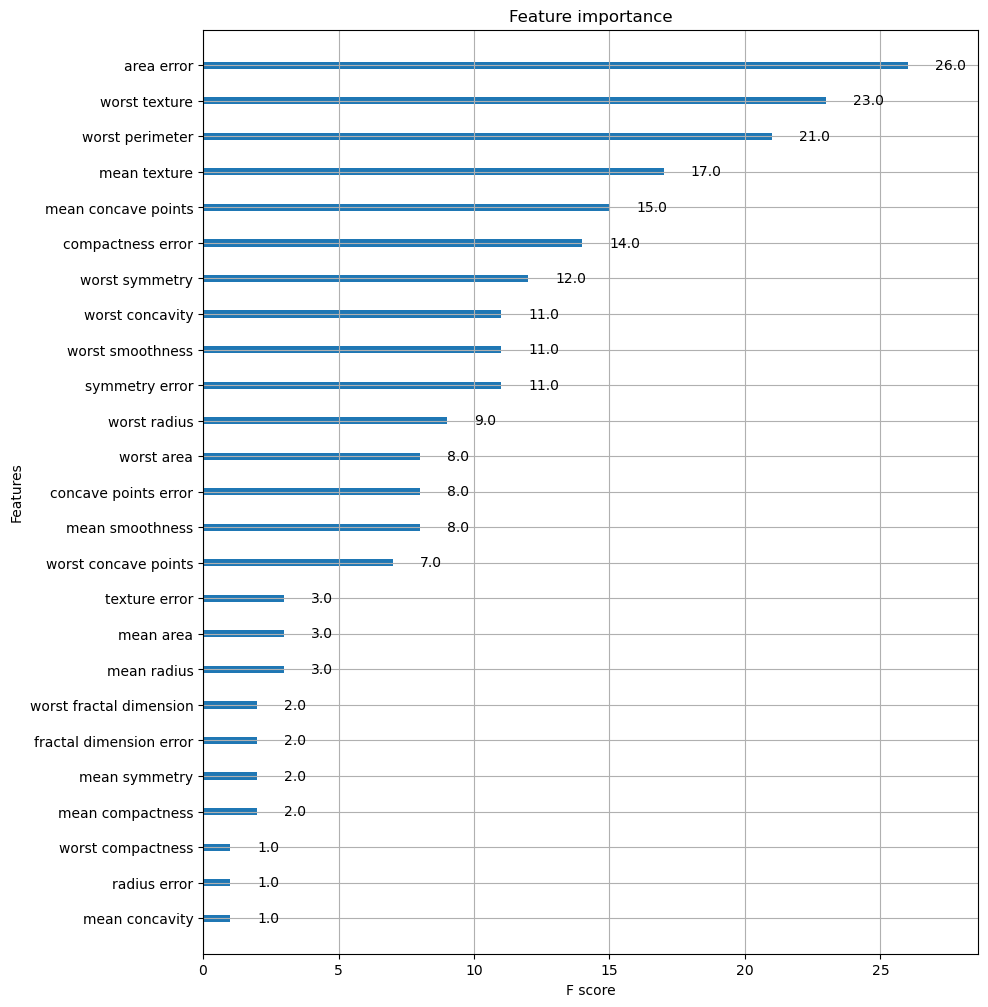

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize = (10,12))
plot_importance(xgb_model, ax = ax)

파이썬 래퍼 XGBoost는 사이킷런의 GridSearchCV와 유사하게 데이터셋에 대한 교차검증 후 최적 파라미터를 구할 수 있는 방법을 cv() API로 제공  
cv()파라미터 설명  
params (dict) : 부스터 파라미터  
dtrain (DMatrix) : 학습 데이터  
num_boost_round (int) : 부스팅 반복 횟수  
nfold (int) : CV 폴드 개수  
stratified (bool) : CV 수행 시 층화 표본 추출 수행 여부  
metrics (string or list of strings) : CV 수행 시 모니터링 할 성능 평가 지표  
early_stopping_rounds (int) : 조기 중단을 활성화시킴, 반복 횟수 지정

## 사이킷런 래퍼 XGBoost의 개요 및 적용
다른 Estimator와 동일하게 fit()과 predict()만으로 학습과 예측이 가능하고, GridSearchCV, Pipeline 등 사이킷런의 다른 유틸리티를 그대로 사용할 수 있음  
파이썬 래퍼 XGBoost와 하이퍼파라미터 차이  
eta -> learing_rate  
sub_sample -> subsample  
lambda -> reg_lambda  
alpha -> reg_alpha

In [21]:
#사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

#Warning 메시지를 없애기 위해 eval_metric값을 XGBClassifier 생성 인자로 입력
xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate = 0.05, max_depth = 3,
                            eval_metric = 'logloss')
xgb_wrapper.fit(X_train, y_train, verbose = True)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

In [22]:
get_clf_eval(y_test, w_preds, w_pred_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870, F1: 0.9744, AUC: 0.9954


사이킷런 XGBoost에서 조기중단 수행  
조기 중단 관련 파라미터를 fit()에 입력  
early_stopping_rounds: 평가 지표가 향상될 수 있는 반복 횟수 정의  
eval_metric: 조기 중단을 위한 평가 지표  
eval_set: 성능 평가를 수행할 데이터셋

In [24]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate = 0.05, max_depth = 3)
evals = [(X_tr, y_tr), (X_val, y_val)]
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds = 50, eval_metric = 'logloss',
                eval_set = evals, verbose = True)

ws50_preds = xgb_wrapper.predict(X_test)
ws50_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.65016	validation_1-logloss:0.66183
[1]	validation_0-logloss:0.61131	validation_1-logloss:0.63609
[2]	validation_0-logloss:0.57563	validation_1-logloss:0.61144
[3]	validation_0-logloss:0.54310	validation_1-logloss:0.59204
[4]	validation_0-logloss:0.51323	validation_1-logloss:0.57329
[5]	validation_0-logloss:0.48447	validation_1-logloss:0.55037
[6]	validation_0-logloss:0.45796	validation_1-logloss:0.52930
[7]	validation_0-logloss:0.43436	validation_1-logloss:0.51534
[8]	validation_0-logloss:0.41150	validation_1-logloss:0.49718
[9]	validation_0-logloss:0.39027	validation_1-logloss:0.48154
[10]	validation_0-logloss:0.37128	validation_1-logloss:0.46990
[11]	validation_0-logloss:0.35254	validation_1-logloss:0.45474
[12]	validation_0-logloss:0.33528	validation_1-logloss:0.44229
[13]	validation_0-logloss:0.31892	validation_1-logloss:0.42961
[14]	validation_0-logloss:0.30439	validation_1-logloss:0.42065
[15]	validation_0-logloss:0.29000	validation_1-logloss:0.40958
[1

In [26]:
get_clf_eval(y_test, ws50_preds, ws50_pred_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740, F1: 0.9677, AUC: 0.9933


In [27]:
#early_stopping_rounds를 10으로 설정하고 재학습
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds = 10, eval_metric = 'logloss',
                eval_set = evals, verbose = True)
ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]
get_clf_eval(y_test, ws10_preds, ws10_pred_proba)

[0]	validation_0-logloss:0.65016	validation_1-logloss:0.66183
[1]	validation_0-logloss:0.61131	validation_1-logloss:0.63609
[2]	validation_0-logloss:0.57563	validation_1-logloss:0.61144
[3]	validation_0-logloss:0.54310	validation_1-logloss:0.59204
[4]	validation_0-logloss:0.51323	validation_1-logloss:0.57329
[5]	validation_0-logloss:0.48447	validation_1-logloss:0.55037
[6]	validation_0-logloss:0.45796	validation_1-logloss:0.52930
[7]	validation_0-logloss:0.43436	validation_1-logloss:0.51534
[8]	validation_0-logloss:0.41150	validation_1-logloss:0.49718
[9]	validation_0-logloss:0.39027	validation_1-logloss:0.48154
[10]	validation_0-logloss:0.37128	validation_1-logloss:0.46990
[11]	validation_0-logloss:0.35254	validation_1-logloss:0.45474
[12]	validation_0-logloss:0.33528	validation_1-logloss:0.44229
[13]	validation_0-logloss:0.31892	validation_1-logloss:0.42961
[14]	validation_0-logloss:0.30439	validation_1-logloss:0.42065
[15]	validation_0-logloss:0.29000	validation_1-logloss:0.40958
[1

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

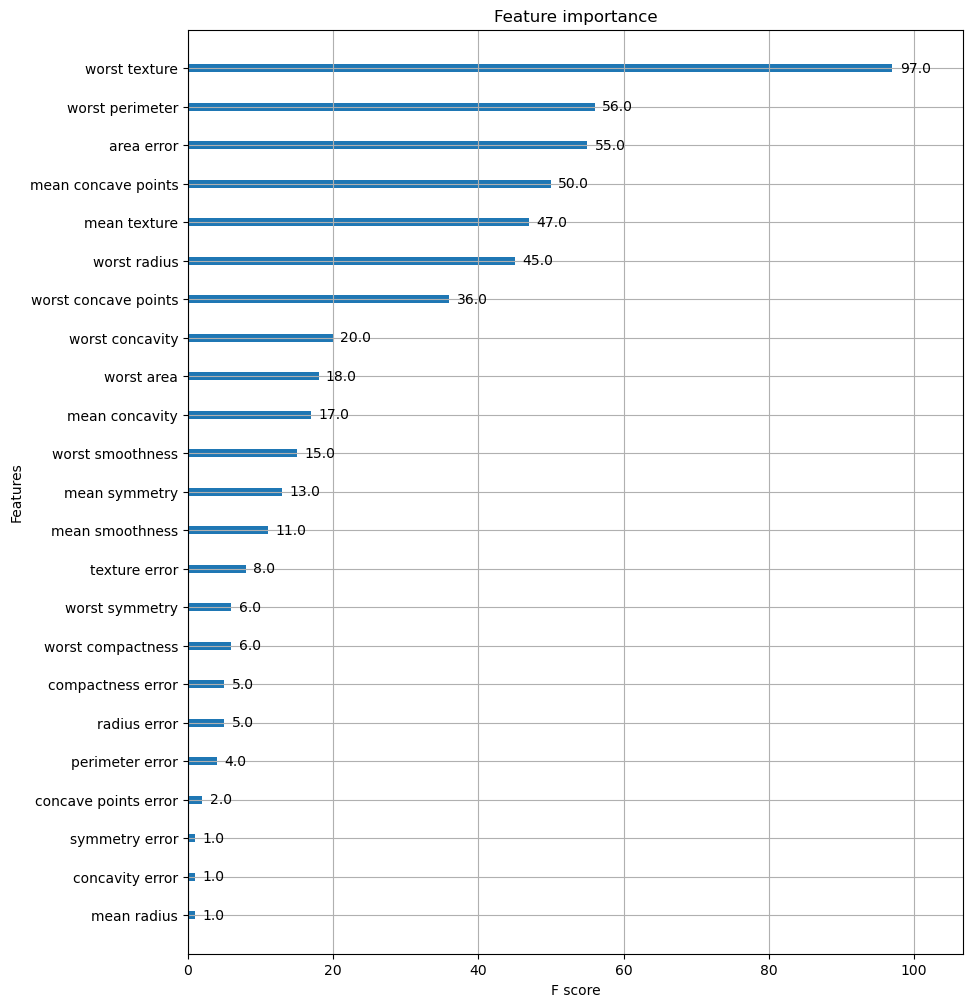

In [29]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize = (10,12))
#사이킷런 래퍼 클래스를 입력해도 무방.
plot_importance(xgb_wrapper, ax = ax)